In [1]:
import itertools, logging, re, string, sys
from collections import defaultdict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

sh = logging.StreamHandler(sys.stderr)
sh.setLevel(logging.INFO)
fmt = '%(asctime)s %(message)s'
dfmt = '%y-%m-%d  %H:%M:%S'
logging.basicConfig(handlers=(sh,), format=fmt, datefmt=dfmt, level=logging.INFO)

# Read Data

Read printer data into a DataFrame and subset it into those that already have VIAF IDs and those that don't. 

Plot total texts, texts with IDs, texts without IDs

In [2]:
printers_data_file = 'data/printers_etc.csv'
printers_df = pd.read_csv(printers_data_file)

# This is necessary because some parsedDates have two years (this needs to be fixed)
# So we just keep the first year and then turn the whole column to ints
printers_df['parsedDate'] = printers_df['parsedDate'].str[:4]
printers_df['parsedDate'] = pd.to_numeric(printers_df['parsedDate'])

viaf_exists = printers_df[~printers_df['viafId'].isna()]
viaf_needed = printers_df[printers_df['viafId'].isna()]

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (7,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Total Number of texts:  80,153
Texts with VIAF IDs:    15,927
Texts without VIAF IDs: 64,226


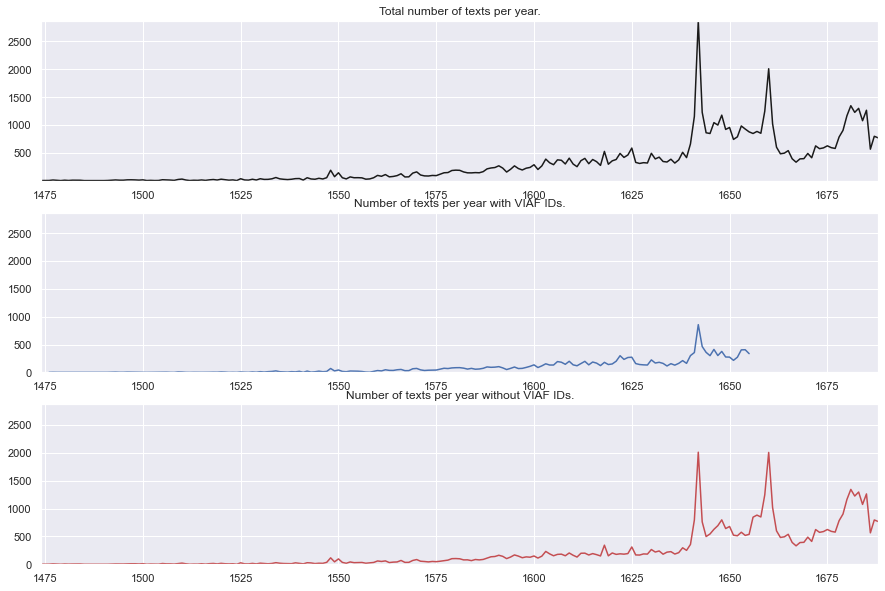

In [3]:
# Change these values to zoom in on shorter yearspans
start_year = 1400
end_year = 1750

total_counts = printers_df.groupby(['parsedDate'])['parsedDate'].count()
viaf_exists_counts = viaf_exists.groupby(['parsedDate'])['parsedDate'].count()
viaf_needed_counts = viaf_needed.groupby(['parsedDate'])['parsedDate'].count()

# Set up the plot
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,10))
grid = plt.GridSpec(3,1)
axes = [fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[1, 0]), fig.add_subplot(grid[2, 0])]

sns.lineplot(data=total_counts, x=total_counts.index, y=total_counts.values, color='k', ax=axes[0])
sns.lineplot(data=viaf_exists_counts, x=viaf_exists_counts.index, y=viaf_exists_counts.values, color='b', ax=axes[1])
sns.lineplot(data=viaf_needed_counts, x=viaf_needed_counts.index, y=viaf_needed_counts.values, color='r', ax=axes[2])

start_year = start_year if int(total_counts.index[0]) < start_year else int(total_counts.index[0])
end_year = end_year if int(total_counts.index[-1]) > end_year else int(total_counts.index[-1])
axes[0].set(xlim=(start_year, end_year), ylim=(1, max(total_counts.values)), xlabel=None, title='Total number of texts per year.')
axes[1].set(xlim=(start_year, end_year), ylim=(0, max(total_counts.values)), xlabel=None, title='Number of texts per year with VIAF IDs.')
axes[2].set(xlim=(start_year, end_year), ylim=(0, max(total_counts.values)), xlabel=None, title='Number of texts per year without VIAF IDs.')

print('Total Number of texts:  {:,}\nTexts with VIAF IDs:    {:,}\nTexts without VIAF IDs: {:,}'\
          .format(len(printers_df), len(viaf_exists), len(viaf_needed)))

### Replace viaf_needed with a small subset to speed up testing

In [4]:
viaf_needed

#viaf_needed = viaf_needed[:10000]

,tcpid,role,role_edited,name,source,title,author,parsedDate,date,place,pubStmt,nameResolved,viafId
0,A18343,printer,printer,Colard Mansion,tcp_ep,"[T]o the right noble, right excellent [and] ve...","Jacobus, de Cessolis, fl. 1288-1322",1474.0,1474 (31 March)],NaN,"Printed by William Caxton and Colard Mansion, ...",NaN,NaN
1,A18343,printer,printer,William Caxton,tcp_ep,"[T]o the right noble, right excellent [and] ve...","Jacobus, de Cessolis, fl. 1288-1322",1474.0,1474 (31 March)],NaN,"Printed by William Caxton and Colard Mansion, ...",NaN,NaN
2,A06567,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,Stans puer ad mensam,"Lydgate, John, 1370?-1451?",1476.0,1476?],NaN,"Printed by William Caxton, [Westminster : 1476?]",NaN,NaN
4,A18231,printer,printer,William Caxton,tcp_ep,Hic incipit paruus Catho,"Cato, Marcus Porcius, 234-149 B.C., attributed...",1476.0,1476],NaN,"Printed by William Caxton, [Westminster : 1476]",NaN,NaN
5,A06543,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,[The chorle and the birde],"Lydgate, John, 1370?-1451?",1477.0,1477?],NaN,"W. Caxton, [Westminster : 1477?]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80148,B43983,publisher,publisher,J. Clarke,tcp_ep,Shrowsbury for me: being a song in praise of t...,NaN,NaN,[between 1681 and 1684],NaN,"Printed for J. Wright, J. Clarke, W. Thackeray...",NaN,NaN
80149,B43983,publisher,publisher,J. Wright,tcp_ep,Shrowsbury for me: being a song in praise of t...,NaN,NaN,[between 1681 and 1684],NaN,"Printed for J. Wright, J. Clarke, W. Thackeray...",NaN,NaN
80150,B43983,publisher,publisher,T. Passenger,tcp_ep,Shrowsbury for me: being a song in praise of t...,NaN,NaN,[between 1681 and 1684],NaN,"Printed for J. Wright, J. Clarke, W. Thackeray...",NaN,NaN
80151,B43983,publisher,publisher,W. Thackeray,tcp_ep,Shrowsbury for me: being a song in praise of t...,NaN,NaN,[between 1681 and 1684],NaN,"Printed for J. Wright, J. Clarke, W. Thackeray...",NaN,NaN


## Some early Exploration about common misspellings into the database
These numbers may be low but remember this is of the names that have not already been asigned a identifier (i.e. half the database)

So far I compared John-Iohn, William-Wyllyam, and counted number of "me "

In [5]:
#compare john to iohn
#create a mask for john and John
john_mask = viaf_needed["name"].str.contains("John", case=False)
#count the number of times the mask evaluated to true
john_count = john_mask.sum()
#create a mask for iohn and Iohn
iohn_mask = viaf_needed["name"].str.contains("Iohn", case=False)
#count the number of times the mask evaluated to true
iohn_count = iohn_mask.sum()
print(f"Number of occurrences of 'John' or 'john': {john_count} \n Number of occurrences of 'Iohn' or 'iohn': {iohn_count}")
#compare william to wyllyam (same procedure as above)
will_mask = viaf_needed["name"].str.contains("William", case=False)
will_count = will_mask.sum()
wyyll_mask = viaf_needed["name"].str.contains("Wyllyam", case=False)
wyll_count = wyyll_mask.sum()
print(f"Number of occurrences of 'William' or 'william': {will_count} \n Number of occurrences of 'Wyllyam' or 'wyllyam': {wyll_count}")
#number of occurences of "me " at beginning of name
# Define a regular expression pattern to match "me " at the beginning of each cell. ^ = beginning of the text
pattern = r"^me "
# Count the number of times the pattern occurs in each cell of the "name" column
counts = viaf_needed["name"].str.count(pattern)
# Sum the count of pattern occurrences to get the total count
total_count = counts.sum()
# Print the total count
print("Number of occurrences of 'me ' at the beginning of each cell:", total_count)

Number of occurrences of 'John' or 'john': 4973 
 Number of occurrences of 'Iohn' or 'iohn': 1773
Number of occurrences of 'William' or 'william': 2450 
 Number of occurrences of 'Wyllyam' or 'wyllyam': 34
Number of occurrences of 'me ' at the beginning of each cell: 69


# Edit Distance Calculations

The following section uses the python module Levenshtein* to count the edit distance. 
The script works by looping through the list of names and calculating the distance between names. The distance value that is calculated is the number of edits; therefore, fewer edits is better. The number of edits is capped with the threshold variable, and changing this to a lower number will great fewer yet higher fidelity results. 

After calculating the distance the script then creates a list of three closest names that are less than 10 edits away. If there is at least one similar name passing the threshold, it is outputted at the end.

However, the metric is far from perfect. The following sections clean the data for better results.

*The Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other. [Wikiapedia](https://en.wikipedia.org/wiki/Levenshtein_distance) 

In [ ]:
#levenshtein (edit) distance
import Levenshtein

# Get a list of unique names in the "Name" column
names = viaf_needed["name"].unique()

# Create an empty dictionary to store the results
result_dict = {}

# Set the maximum number of edits allowed between the names
threshold = 10

# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        # Calculate the Levenshtein distance between the two names
        distance = Levenshtein.distance(name, name2, weights=(2,2,1))
        
        # Store the distance in the distances list
        if distance < threshold:
            distances.append((name2, distance))
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")


# Improving Levenshtein

The following section improves on the process by removing "me " from the beginning of the names column and by removing all punctuation

It also reduces the total number of edits allowed (i.e. threshold) to create higher fidelity results.

In [ ]:
#levenshtein (edit) distance (without "me ")
viaf_needed["name"] = viaf_needed["name"].str.replace("^me ", "", regex=True)

#remove punctuation
punctuation = string.punctuation

viaf_needed["name"] = viaf_needed["name"].str.replace(f"[{punctuation}]", "",regex=True)

# Get a list of unique names in the "Name" column
names = viaf_needed["name"].unique()

# Create an empty dictionary to store the results
result_dict = {}

# Set the maximum number of edits allowed between the names
threshold = 4

# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        # Calculate the Levenshtein distance between the two names
        distance = Levenshtein.distance(name, name2, weights=(2,2,1))
        
        # Store the distance in the distances list
        if distance < threshold:
            distances.append((name2, distance))
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")

# Name Spliting function

Let's put in all the preprocessing steps into the name_preprocess function so that we can just call it on a name and get as close to a clean (firstname, lastname) tuple as possible.

Below are two functions. name_preprocess tries to remove erroneous names while name_preprocess just separates the string based on the first whitespace

Example output:<br>
John Smith -> ('John', 'Smith')<br>
John. Smyth -> ('John', 'Smyth')<br>
Wynken de Worde -> ('Wynken', 'de Worde')<br>
'printed at the sign of the fox' -> None (i.e. doesn't look like a legit name)

#### Note: A trick to try later. Learn the vocabulary used in all name strings and ignore frequently used words like 'active' etc

In [7]:
#remove 'me' and punctuation
#punctuation = string.punctuation
#viaf_needed.loc[:, "name"] = viaf_needed["name"].str.replace("^me ", "", regex=True)
#viaf_needed.loc[:, "name"] = viaf_needed["name"].str.replace(f"[{punctuation}]", "",regex=True)

def name_preprocess(full_name, max_length=30, min_tokens=2, max_tokens=4):
    #ignore names that are too long
    if len(full_name) > max_length:
        logging.info(f'Too long: Ignoring: {full_name}')
        return None
    #find all strings separated by whitespace
    words = re.findall(r'\b\w+\b', full_name)
    # check if the number of words is at least 2 or over 4
    if len(words) < min_tokens:
        logging.info(f'Too few tokens: Ignoring: {full_name}')
        return None
    if len(words) > max_tokens:
        logging.info(f'Too many tokens: Ignoring: {full_name}')
        return None
    # return the first word and remaining string as a tuple
    first_name = words[0].lower()
    last_name = ' '.join(words[1:]).lower()
    return (first_name, last_name)

# simple function that splits name
def name_preprocess_simple(full_name):
    words = re.findall(r'\b\w+\b', full_name)
    first_name = words[0]
    last_name = ' '.join(words[1:])
    return (first_name, last_name)

# Using Strsimpy

In order to further improve the levenshtein we can use another python module called strsimpy which allows us to weight the subsitutions. Below we set reduced costs for certain common letter replacements.

Key goal heare is to reduce the number of name-pairs we run through the Weighted Levenshtein function.

We'll parse names into (firstname, lastname) tuples. Then, for each pair we should check firstname against firstname and lastname against lastname. We retain a pair if 1> First and Lastnames start with the same initials, 2> They are roughly same in length (these criteria need to be refined later)

In [8]:
from strsimpy.weighted_levenshtein import WeightedLevenshtein

substitution_cost_dict = {('i', 'j'): 0.5,
                          ('j', 'i'): 0.5,
                          ('u', 'v'): 0.3,
                          ('v', 'u'): 0.3,
                          ('i', 'y'): 0.3, 
                          ('y', 'i'): 0.3}

weighted_levenshtein = WeightedLevenshtein(substitution_cost_fn=lambda x, y: substitution_cost_dict[(x,y)] if (x, y) in substitution_cost_dict else 1.0)

# Get a list of unique names in the "Name" column
names = [name_preprocess(name) for name in viaf_needed["name"].unique() if name_preprocess(name)!=None]

name_pairs = itertools.combinations(names, 2)
name_pairs = [((f1, l1), (f2, l2)) for (f1, l1), (f2, l2) in name_pairs if ((f1[0]==f2[0]) and (l1[0]==l2[0]))]

print(f'Total number if name-pairs to compute distances on: {len(name_pairs)}')
print(name_pairs[:10])

23-02-18  18:45:48 Too long: Ignoring: Caxton, William, approximately 1422-1491 or 1492,
23-02-18  18:45:48 Too long: Ignoring: Rivers, Anthony Woodville, Earl of, 1442? 1483,
23-02-18  18:45:48 Too long: Ignoring: [s] lettou [et] Will[es] de machlinia i citate Londonia[rum]
23-02-18  18:45:48 Too long: Ignoring: me Wilhelmum de Mechlinia impressus
23-02-18  18:45:48 Too long: Ignoring: one some tyme scole mayster of saynt Albons, vppon whoos soule god haue mercy. Amen. And newely
23-02-18  18:45:48 Too long: Ignoring: Copland, Robert, active 1508-1547,
23-02-18  18:45:48 Too long: Ignoring: the fron ballaunce &amp;c. Emprinted
23-02-18  18:45:48 Too long: Ignoring: Notary, Julian, active 1496-1520,
23-02-18  18:45:48 Too long: Ignoring: Watson, Henry, active 1500-1518,
23-02-18  18:45:48 Too many tokens: Ignoring: me Iulyan Notary dwelly[n]g
23-02-18  18:45:48 Too long: Ignoring: the co[m]au[n]dement of the reuerend faher i god
23-02-18  18:45:48 Too long: Ignoring: Fox, Richarde, app

23-02-18  18:45:48 Too few tokens: Ignoring: Dwellyng
23-02-18  18:45:48 Too long: Ignoring: Willyam Seres. Dwellyng wythout Aldersgate.
23-02-18  18:45:48 Too long: Ignoring: Rice, Richard, active 1548-1579,
23-02-18  18:45:48 Too long: Ignoring: Chaloner, Thomas, Sir, 1521 1625,
23-02-18  18:45:48 Too few tokens: Ignoring: Septennium]
23-02-18  18:45:48 Too long: Ignoring: Reginald, Henry, active 1548-1549,
23-02-18  18:45:48 Too long: Ignoring: Some, Thomas, approximately 1510-
23-02-18  18:45:48 Too many tokens: Ignoring: Hoby, Thomas, Sir, 1530 1566,
23-02-18  18:45:48 Too many tokens: Ignoring: Old, John, active 1545-1555,
23-02-18  18:45:48 Too long: Ignoring: Wyer, Robert, active 1530-1556,
23-02-18  18:45:48 Too long: Ignoring: Lützelburger, Hans, 1495? 1526,
23-02-18  18:45:48 Too few tokens: Ignoring: Ludgate
23-02-18  18:45:48 Too many tokens: Ignoring: the wydowe of Ihon Herforde
23-02-18  18:45:48 Too long: Ignoring: Castellion, Sébastien, 1515 1563,
23-02-18  18:45:48 

23-02-18  18:45:48 Too long: Ignoring: Newcomen, Elias, 1547 or 1548-1614,
23-02-18  18:45:48 Too long: Ignoring: Higgins, John, active 1570-1602,
23-02-18  18:45:48 Too long: Ignoring: Sadler, John, -approximately 1595,
23-02-18  18:45:48 Too long: Ignoring: Norton, Robert, minister of the worde in Suffolke,
23-02-18  18:45:48 Too many tokens: Ignoring: T. W., active 1573-1595,
23-02-18  18:45:48 Too long: Ignoring: Browne, Thomas, approximately 1535-1585,
23-02-18  18:45:48 Too long: Ignoring: Jugge, Richard, approximately 1514-1577,
23-02-18  18:45:48 Too long: Ignoring: Vitell, Christopher, active 1555-1579,
23-02-18  18:45:48 Too many tokens: Ignoring: Jones, John, active 1562-1579,
23-02-18  18:45:48 Too long: Ignoring: Rychard Tottel the vi.day of December
23-02-18  18:45:48 Too long: Ignoring: Grantham, Henry, active 1571-1587,
23-02-18  18:45:48 Too long: Ignoring: Iohannem Bellerum [i.e. William Carter]
23-02-18  18:45:48 Too few tokens: Ignoring: . London
23-02-18  18:45:48 

23-02-18  18:45:48 Too long: Ignoring: S. Milanges [i.e. T. Orwin], ordinarie
23-02-18  18:45:48 Too long: Ignoring: Martin Iunior, without any priuiledge of the Catercaps
23-02-18  18:45:48 Too many tokens: Ignoring: Iohn Astile [i.e. T. Orwin]
23-02-18  18:45:48 Too many tokens: Ignoring: Pepper Allie [i.e. printed
23-02-18  18:45:48 Too long: Ignoring: Signior Some-body [i.e. Eliot's Court Press?]
23-02-18  18:45:48 Too long: Ignoring: the deputies of Christopher Barker, printer the Queenes most excellent Maiestie
23-02-18  18:45:48 Too long: Ignoring: the Deputies of Christopher Barker
23-02-18  18:45:48 Too long: Ignoring: Martin Junior [i.e. John Charlewood]
23-02-18  18:45:48 Too long: Ignoring: the Vniversitie of Cambridge. And
23-02-18  18:45:48 Too many tokens: Ignoring: White, John, active 1585-1593,
23-02-18  18:45:48 Too many tokens: Ignoring: Veen, Gijsbert van, 1558 1630,
23-02-18  18:45:48 Too long: Ignoring: Ioannis Wecheli, sumtibus vero Theodori de Bry
23-02-18  18:4

23-02-18  18:45:49 Too few tokens: Ignoring: Oxford]
23-02-18  18:45:49 Too many tokens: Ignoring: N. L[ing,] C. B[urby]
23-02-18  18:45:49 Too long: Ignoring: Bartelmew Sermartelli [i.e. J. Windet]
23-02-18  18:45:49 Too long: Ignoring: the Kings most Excellent Maiestie
23-02-18  18:45:49 Too long: Ignoring: Marlowe, Christopher, 1564 1593,
23-02-18  18:45:49 Too few tokens: Ignoring: R
23-02-18  18:45:49 Too long: Ignoring: Eliot's Court Press] Impensis Geor. Bishop
23-02-18  18:45:49 Too long: Ignoring: the heires of D. Turner [i.e. T. Creede]
23-02-18  18:45:49 Too many tokens: Ignoring: the assent of Thomas Morley
23-02-18  18:45:49 Too long: Ignoring: W.W. (William Watson), 1559? 1603,
23-02-18  18:45:49 Too long: Ignoring: Johnson, Robert, active 1586-1626,
23-02-18  18:45:49 Too long: Ignoring: Arnold Coninx [i.e. English secret press]]
23-02-18  18:45:49 Too long: Ignoring: the heires of Ia. Walker [i.e. Thomas Creede]
23-02-18  18:45:49 Too many tokens: Ignoring: the widow of

23-02-18  18:45:49 Too long: Ignoring: the Vniuersitie of Cambridge. 1611. And
23-02-18  18:45:49 Too long: Ignoring: the Vniuersitie of Cambridge 1611. And
23-02-18  18:45:49 Too long: Ignoring: Peake, Robert, Sir, 1592? 1667,
23-02-18  18:45:49 Too many tokens: Ignoring: Aston, Edward, 1573 or 1574-
23-02-18  18:45:49 Too long: Ignoring: typographica: Ioannis Laquehay, via Iudæ]
23-02-18  18:45:49 Too long: Ignoring: Smyth, Roger, 1541 1624 or 1625,
23-02-18  18:45:49 Too many tokens: Ignoring: T.S. For Richard Boyle
23-02-18  18:45:49 Too many tokens: Ignoring: the Honorable Citty of London
23-02-18  18:45:49 Too long: Ignoring: Iohn Franckton printer and stationer to the Kings Maiestie
23-02-18  18:45:49 Too long: Ignoring: Thomas Finlason, typographus Reg. Majest.
23-02-18  18:45:49 Too long: Ignoring: the Vniuersitie of Cambridge. 1612. And
23-02-18  18:45:49 Too many tokens: Ignoring: T. Thorp. and to be
23-02-18  18:45:49 Too long: Ignoring: Martin, James, active 1615-1630,
23-

23-02-18  18:45:49 Too long: Ignoring: Overbury, Thomas, Sir, 1581 1613,
23-02-18  18:45:49 Too long: Ignoring: Aert Meuris boeckvercooper [i.e. E. Allde?]
23-02-18  18:45:49 Too many tokens: Ignoring: Iohn Bellamine [i.e. Bellamie]
23-02-18  18:45:49 Too long: Ignoring: Potter, Christopher, 1591 1646,
23-02-18  18:45:49 Too long: Ignoring: George Veseler. The 5. of Iuly. [
23-02-18  18:45:49 Too long: Ignoring: George Veseler. The 9. of Iuly. [
23-02-18  18:45:49 Too many tokens: Ignoring: Ioris Veseler. [i.e. s.n.]
23-02-18  18:45:49 Too long: Ignoring: Broer Ionson, corranter to his excellencie
23-02-18  18:45:49 Too long: Ignoring: Broyer Iohnson corantere to his excellency
23-02-18  18:45:49 Too long: Ignoring: N. B[utter] September the 24. 1621. out of the Hie Dutch coppy printed
23-02-18  18:45:49 Too long: Ignoring: N. B[utter] according to the Dutch copy
23-02-18  18:45:49 Too long: Ignoring: N. B[utter] [sic] October the 2. 1621. Out of the Hie Dutch coppy
23-02-18  18:45:49 

23-02-18  18:45:49 Too long: Ignoring: Martin Bogart, vnder the signe of Paris
23-02-18  18:45:49 Too long: Ignoring: Cary, Elizabeth, Lady, 1585 or 1586-1639,
23-02-18  18:45:49 Too many tokens: Ignoring: the widovve of Marke Wyon
23-02-18  18:45:49 Too many tokens: Ignoring: W. I., active 17th century,
23-02-18  18:45:49 Too long: Ignoring: Tobie, Matthew, Sir, 1577 1655,
23-02-18  18:45:49 Too long: Ignoring: the Kings most Excellent Maiestie: and
23-02-18  18:45:49 Too many tokens: Ignoring: the Assignes of Iohn Bill
23-02-18  18:45:49 Too long: Ignoring: the Kings most excellent Maiestie: and
23-02-18  18:45:49 Too long: Ignoring: Kings [sic] most excellent Maiestie
23-02-18  18:45:49 Too many tokens: Ignoring: William Iones of Iohn Bellamy
23-02-18  18:45:49 Too long: Ignoring: the Kings most Excellent Maiestie and
23-02-18  18:45:49 Too many tokens: Ignoring: P. S. P., active 1630,
23-02-18  18:45:49 Too long: Ignoring: the Kings most excellent Maiestie: And
23-02-18  18:45:49 T

23-02-18  18:45:49 Too long: Ignoring: Marshall, William, active 1617-1659,
23-02-18  18:45:49 Too long: Ignoring: Isaack van Waesberghe, upon the Steygher
23-02-18  18:45:49 Too long: Ignoring: the printers to the Vniversitie
23-02-18  18:45:49 Too long: Ignoring: the Kings most Excellent Maiesty: and
23-02-18  18:45:49 Too long: Ignoring: James King of England, I, 1566 1625,
23-02-18  18:45:49 Too long: Ignoring: Stirling, William Alexander, Earl of, 1567 or 1568-1640,
23-02-18  18:45:49 Too many tokens: Ignoring: M.P. pro Ro. Milbourne
23-02-18  18:45:49 Too long: Ignoring: the Kings most excellent Majesty
23-02-18  18:45:49 Too long: Ignoring: the Kings most Excellent Majesty
23-02-18  18:45:49 Too long: Ignoring: Monmouth, Henry Carey, Earl of, 1596 1661,
23-02-18  18:45:49 Too long: Ignoring: H. C. [i.e. Cripps? or Curteyn?]
23-02-18  18:45:49 Too many tokens: Ignoring: F. K[ingston] R. Y[oung]
23-02-18  18:45:49 Too many tokens: Ignoring: R[ichard] W[hitaker] And
23-02-18  18:45

23-02-18  18:45:49 Too long: Ignoring: the Kings most excellent Majestie: And
23-02-18  18:45:49 Too long: Ignoring: the Kings most excellent majestie: and
23-02-18  18:45:49 Too long: Ignoring: the Kings most Excellent Majesty. And now
23-02-18  18:45:49 Too long: Ignoring: the Kings most Excellent Majesty, and now
23-02-18  18:45:49 Too few tokens: Ignoring: Bandon
23-02-18  18:45:49 Too few tokens: Ignoring: J
23-02-18  18:45:49 Too long: Ignoring: One, who regards rather truth then money
23-02-18  18:45:49 Too many tokens: Ignoring: the good of the Commonweale
23-02-18  18:45:49 Too long: Ignoring: 1642. For the use of the petitioners who
23-02-18  18:45:49 Too many tokens: Ignoring: T.B. this 31 of Ianuary
23-02-18  18:45:49 Too long: Ignoring: warrant and command of the Lords of His Majesties Privie Councell of Scotland
23-02-18  18:45:49 Too long: Ignoring: the Kings most excellent Majesty, and
23-02-18  18:45:49 Too long: Ignoring: the Kings most excellent Majestie, and
23-02-1

23-02-18  18:45:49 Too long: Ignoring: George Calvert, of Austins parish
23-02-18  18:45:49 Too many tokens: Ignoring: the Honorable House of COmmons
23-02-18  18:45:49 Too long: Ignoring: Evan Tyler, printer t[o] the Kings most Excellent Majesty
23-02-18  18:45:49 Too few tokens: Ignoring: stationers.
23-02-18  18:45:49 Too many tokens: Ignoring: John Hancock, and to be
23-02-18  18:45:49 Too long: Ignoring: the better edification of Mr. Dels selected and peculiar people.
23-02-18  18:45:49 Too long: Ignoring: Evan Tyler his Majesites printer
23-02-18  18:45:49 Too long: Ignoring: order of the Committee of Estates
23-02-18  18:45:49 Too many tokens: Ignoring: the good of Great Britiane
23-02-18  18:45:49 Too long: Ignoring: Middleton, Thomas, active 17th century,
23-02-18  18:45:49 Too long: Ignoring: the kngs [sic] most excellent Majestie, as were the Scotish papers
23-02-18  18:45:49 Too few tokens: Ignoring: H.
23-02-18  18:45:49 Too few tokens: Ignoring: I.
23-02-18  18:45:49 Too 

23-02-18  18:45:49 Too few tokens: Ignoring: J.
23-02-18  18:45:49 Too long: Ignoring: the same authority which caused the Army to oppose the Parliament
23-02-18  18:45:49 Too many tokens: Ignoring: William Bladen and re-printed
23-02-18  18:45:49 Too many tokens: Ignoring: T. Broad, and re-printed
23-02-18  18:45:49 Too long: Ignoring: the health, of the Common-wealth
23-02-18  18:45:49 Too long: Ignoring: general satisfaction of the Kingdom
23-02-18  18:45:49 Too long: Ignoring: the printer of the House of Lords
23-02-18  18:45:49 Too few tokens: Ignoring: SKG
23-02-18  18:45:49 Too long: Ignoring: generall satisfaction to all the free-born people of England
23-02-18  18:45:49 Too many tokens: Ignoring: the good of the state.
23-02-18  18:45:49 Too many tokens: Ignoring: the good of the State
23-02-18  18:45:49 Too long: Ignoring: France, and all other neighbor nations, that groan under the oppression of tyrannical government
23-02-18  18:45:49 Too long: Ignoring: the information of 

23-02-18  18:45:49 Too few tokens: Ignoring: himself
23-02-18  18:45:49 Too few tokens: Ignoring: Pauls
23-02-18  18:45:49 Too many tokens: Ignoring: the use of the Common-wealth
23-02-18  18:45:49 Too long: Ignoring: Collins, Thomas, active 1650-1682,
23-02-18  18:45:49 Too few tokens: Ignoring: Beare
23-02-18  18:45:49 Too many tokens: Ignoring: John Rothwell, a the Fountaine
23-02-18  18:45:49 Too many tokens: Ignoring: Paul, of St. Ubald, Brother,
23-02-18  18:45:49 Too long: Ignoring: Crosse, Thomas, active 1632-1682,
23-02-18  18:45:49 Too long: Ignoring: Gaywood, Richard, active 1650-1680,
23-02-18  18:45:49 Too long: Ignoring: William Du-Gard,and Henry Hills
23-02-18  18:45:49 Too long: Ignoring: Nevill Simmons booksellor [sic]
23-02-18  18:45:49 Too many tokens: Ignoring: Giles Calvert, and art to be
23-02-18  18:45:49 Too long: Ignoring: Francis Eaglesfield. At the Crown
23-02-18  18:45:49 Too few tokens: Ignoring: Marigold
23-02-18  18:45:49 Too long: Ignoring: Lower, Willia

23-02-18  18:45:49 Too long: Ignoring: T. Ratcliffe pro Georgio Thomasono
23-02-18  18:45:49 Too many tokens: Ignoring: special Order: and re-printed
23-02-18  18:45:49 Too long: Ignoring: Henry Sutton mathematical instrument-maker
23-02-18  18:45:49 Too long: Ignoring: His Highness the Lord Protector:
23-02-18  18:45:49 Too few tokens: Ignoring: Navy
23-02-18  18:45:49 Too long: Ignoring: Henry Hills, next door to the sign of the Peacock
23-02-18  18:45:49 Too long: Ignoring: John Bartlet the elder, sometimes
23-02-18  18:45:49 Too long: Ignoring: the author Henry Adis uphouldster
23-02-18  18:45:49 Too long: Ignoring: J. H. (John Harding), 1600 or 1601-
23-02-18  18:45:49 Too long: Ignoring: Underhill, Jane, active 1660-1669,
23-02-18  18:45:49 Too long: Ignoring: Miller, Abraham, active 1646-approximately 1661,
23-02-18  18:45:49 Too long: Ignoring: White, Robert, active 1639-1677,
23-02-18  18:45:49 Too many tokens: Ignoring: L. Lichfield and re-printed
23-02-18  18:45:49 Too many 

23-02-18  18:45:49 Too long: Ignoring: Manley, Roger, Sir, 1626? 1688,
23-02-18  18:45:49 Too long: Ignoring: the truly-loyal and suffering officers
23-02-18  18:45:49 Too long: Ignoring: Bernegger, Matthias, 1582 1640,
23-02-18  18:45:49 Too long: Ignoring: Samuel Dancer, next door to the Bear
23-02-18  18:45:49 Too long: Ignoring: the Kings most Excellent Majesty;
23-02-18  18:45:49 Too many tokens: Ignoring: Faber, Albert Otto, 1612 1684,
23-02-18  18:45:49 Too many tokens: Ignoring: J.G. For Nath. Brook
23-02-18  18:45:49 Too long: Ignoring: Joan. Field, impensis Gulielmi Morden
23-02-18  18:45:49 Too long: Ignoring: Samuel Dancer next door to the Bear
23-02-18  18:45:49 Too long: Ignoring: Birchensha, John, active 1664-1672,
23-02-18  18:45:49 Too long: Ignoring: the Society of Bull-Feathers Hall
23-02-18  18:45:49 Too long: Ignoring: Dorset, Charles Sackville, Earl of, 1638? 1706,
23-02-18  18:45:49 Too long: Ignoring: Godolphin, Sidney Godolphin, Earl of, 1645 1712,
23-02-18  18

23-02-18  18:45:50 Too long: Ignoring: William Rawlins over against the Royal Exchange
23-02-18  18:45:50 Too many tokens: Ignoring: R.C. over against the Globe
23-02-18  18:45:50 Too long: Ignoring: Sandwich, Edward Montagu, Earl of, 1625 1672,
23-02-18  18:45:50 Too many tokens: Ignoring: R. Cutler and to be
23-02-18  18:45:50 Too few tokens: Ignoring: Booksellers
23-02-18  18:45:50 Too many tokens: Ignoring: the honorable City of London]
23-02-18  18:45:50 Too many tokens: Ignoring: the author, or to be had
23-02-18  18:45:50 Too long: Ignoring: the satisfaction of his friends
23-02-18  18:45:50 Too many tokens: Ignoring: Cremer, Acton, 1650 or 1651-
23-02-18  18:45:50 Too many tokens: Ignoring: Alsop, William, of West Ham
23-02-18  18:45:50 Too many tokens: Ignoring: Alsop, William, of West Ham,
23-02-18  18:45:50 Too long: Ignoring: Collins, James, active 1664-1681,
23-02-18  18:45:50 Too many tokens: Ignoring: J. Wright, next to the Globe
23-02-18  18:45:50 Too long: Ignoring: Pr

23-02-18  18:45:50 Too few tokens: Ignoring: Will
23-02-18  18:45:50 Too long: Ignoring: Harford, Robert, active 1677-1681,
23-02-18  18:45:50 Too long: Ignoring: Yeates, Nicholas, active 1680-1681,
23-02-18  18:45:50 Too long: Ignoring: Nightingale, Robert, active 1680,
23-02-18  18:45:50 Too long: Ignoring: the Cabalistical Society of the Sages
23-02-18  18:45:50 Too long: Ignoring: Oldisworth, Michael, 1591 1654?,
23-02-18  18:45:50 Too long: Ignoring: C. Bates, next door to the Crown-Tavern
23-02-18  18:45:50 Too long: Ignoring: the King's Most Excellent Majestie;
23-02-18  18:45:50 Too long: Ignoring: John Calderwood stationer, over against the Main Guard
23-02-18  18:45:50 Too many tokens: Ignoring: Compiègne de Veil, Louis de,
23-02-18  18:45:50 Too long: Ignoring: the Justices of the Peace, blank Declarations
23-02-18  18:45:50 Too long: Ignoring: any other court, blank warrants of attorney to confess judgment, or to acknowledge satisfaction
23-02-18  18:45:50 Too long: Ignori

23-02-18  18:45:50 Too long: Ignoring: order of the Governors of the Dutch East-India Company
23-02-18  18:45:50 Too many tokens: Ignoring: John Bill, deceas'd and
23-02-18  18:45:50 Too many tokens: Ignoring: Valois, Henri de, 1603 1676,
23-02-18  18:45:50 Too long: Ignoring: William Freeman over against the Devil-Tavern
23-02-18  18:45:50 Too long: Ignoring: Jos. Ray, sumptibus ejusdem; prostant venales apud Eliph. Dobson, and insignia Stationariorum
23-02-18  18:45:50 Too many tokens: Ignoring: Fox, Thomas, active 1678-1692,
23-02-18  18:45:50 Too long: Ignoring: Hensman, William, active 1671-1700,
23-02-18  18:45:50 Too long: Ignoring: English, Josias, approximately 1630-1718,
23-02-18  18:45:50 Too many tokens: Ignoring: Moore, Jonas, Sir, 1617 1679,
23-02-18  18:45:50 Too long: Ignoring: the loyal young printers, viz. E.
23-02-18  18:45:50 Too long: Ignoring: Norris, James, active 1682-1684,
23-02-18  18:45:50 Too long: Ignoring: the sufferers themselves, from Newgate Prison
23-0

23-02-18  18:45:50 Too long: Ignoring: Smith, Samuel, active 1681-1703,
23-02-18  18:45:50 Too long: Ignoring: D. Mallet, next door to Mr. Shipton's Coffee-House
23-02-18  18:45:50 Too long: Ignoring: E. Mallet, next door to Mr. Shipton's Coffee-house
23-02-18  18:45:50 Too long: Ignoring: Banc, Pieter van der, 1649 1697,
23-02-18  18:45:50 Too many tokens: Ignoring: M. Flesher, impensis C. Brome
23-02-18  18:45:50 Too long: Ignoring: E. Mallet, next door to Mr. Shipton's coffee-house
23-02-18  18:45:50 Too long: Ignoring: E[lizabeth]. Mallet, next door to Mr. Shiptons coffee-house
23-02-18  18:45:50 Too long: Ignoring: D. Mallet, next door to the sign of the Star between Fleet Bridge
23-02-18  18:45:50 Too long: Ignoring: Blount, Walter Kirkham, Sir, -1717,
23-02-18  18:45:50 Too long: Ignoring: Clark, Henry, active 1687-1691,
23-02-18  18:45:50 Too long: Ignoring: W. D. Sir, (William Domvile), 1643 1698,
23-02-18  18:45:50 Too long: Ignoring: Knight, Joseph, active 1684-1691,
23-02-1

23-02-18  18:45:50 Too many tokens: Ignoring: the Booksellers of Pye-corner
23-02-18  18:45:50 Too long: Ignoring: C. Bates next door to the Cro[w]n Tavern
23-02-18  18:45:50 Too long: Ignoring: the use of the friends of the deceased.
23-02-18  18:45:50 Too long: Ignoring: C[harles]. Bates, next the Crown Tavern
23-02-18  18:45:50 Too long: Ignoring: their most excellent [Majesties
23-02-18  18:45:50 Too long: Ignoring: C[harles]. Bates, next the Crown-Cavern
23-02-18  18:45:50 Too long: Ignoring: Queens Most Excellent Majesties
23-02-18  18:45:50 Too long: Ignoring: Charles Bates next to the Crown Tavern
23-02-18  18:45:50 Too long: Ignoring: Queens most excellent Majesties;
23-02-18  18:45:50 Too few tokens: Ignoring: Queen
23-02-18  18:45:50 Too long: Ignoring: Queen's most Excellent Majesties
23-02-18  18:45:50 Too long: Ignoring: Queens Most Excellent Majesties; and re-printed
23-02-18  18:45:50 Too many tokens: Ignoring: the Author's private use
23-02-18  18:45:50 Too long: Ignor

23-02-18  18:45:50 Too long: Ignoring: Howell, John, -approximately 1698,
23-02-18  18:45:50 Too long: Ignoring: &amp; tous les libraires francois
23-02-18  18:45:50 Too few tokens: Ignoring: Junr
23-02-18  18:45:50 Too long: Ignoring: Dalrymple, James, Sir, active 1714,
23-02-18  18:45:50 Too long: Ignoring: Charles Bill, and the Executrix of Thomas Newcomb, deceas'ed
23-02-18  18:45:50 Too long: Ignoring: the Company of the royal fishery of England
23-02-18  18:45:50 Too long: Ignoring: Parker, Peter, active 1665-1703,
23-02-18  18:45:50 Too many tokens: Ignoring: J. Wickins, and to be
23-02-18  18:45:50 Too long: Ignoring: Brome, Charles, active 1687-1700,
23-02-18  18:45:50 Too long: Ignoring: Chapman, Thomas, active 1687-1709,
23-02-18  18:45:50 Too long: Ignoring: Harley, Edward, Sir, 1624 1700,
23-02-18  18:45:50 Too long: Ignoring: R. B., active approximately 1695,
23-02-18  18:45:50 Too many tokens: Ignoring: A. M[ilbourn] W. O[nley]
23-02-18  18:45:50 Too long: Ignoring: Chur

23-02-18  18:45:50 Too long: Ignoring: S. Keble bibliopolæ, ad insigne capitis turcarum imperatoris
23-02-18  18:45:50 Too few tokens: Ignoring: Parkhurst
23-02-18  18:45:50 Too long: Ignoring: Edwin, Humphrey, Sir, 1642 1707,
23-02-18  18:45:50 Too many tokens: Ignoring: Moore, John, Sir, 1620 1702,
23-02-18  18:45:50 Too long: Ignoring: Oldmixon, Mr. (John), 1673 1742,
23-02-18  18:45:50 Too long: Ignoring: Shaftesbury, Anthony Ashley Cooper, Earl of, 1671 1713,
23-02-18  18:45:50 Too long: Ignoring: Sam. Lowndes over-against Exeter-Exchange
23-02-18  18:45:50 Too many tokens: Ignoring: Tho. Mace, of Trin. Coll.
23-02-18  18:45:50 Too long: Ignoring: the heirs and successors of Andrew Anderson ..
23-02-18  18:45:50 Too many tokens: Ignoring: One of His Majesties Printers
23-02-18  18:45:50 Too long: Ignoring: Offley, William, 1659 or 1660-1724,
23-02-18  18:45:50 Too many tokens: Ignoring: J.M., impensis R. Wilkin
23-02-18  18:45:50 Too long: Ignoring: Charles Bill, and the executrix

23-02-18  18:45:50 Too few tokens: Ignoring: Francis
23-02-18  18:45:50 Too few tokens: Ignoring: Wright
23-02-18  18:45:50 Too many tokens: Ignoring: J. Hose next the Rose
23-02-18  18:45:50 Too many tokens: Ignoring: F. C. J. W. T. V. W. G.


Total number if name-pairs to compute distances on: 309351
[(('colard', 'mansion'), ('coverdale', 'miles 1488 1568')), (('colard', 'mansion'), ('claude', 'morell')), (('colard', 'mansion'), ('christopher', 'meredith')), (('colard', 'mansion'), ('ch', 'meredith')), (('colard', 'mansion'), ('c', 'meredith')), (('colard', 'mansion'), ('christopher', 'meredeth')), (('colard', 'mansion'), ('c', 'm eredith')), (('colard', 'mansion'), ('casaubon', 'meric 1599 1671')), (('colard', 'mansion'), ('c', 'meredith')), (('colard', 'mansion'), ('c', 'meredith'))]


In [9]:
# dictionaries to store the results and distances
distances = defaultdict(dict)

# Set the maximum number of edits allowed between the names
threshold = 6

for (f1, l1), (f2, l2) in name_pairs:
    distance = weighted_levenshtein.distance(f1, f2) + weighted_levenshtein.distance(l1, l2)
    distances[(f1, l1)][(f2, l2)] = distance
    distances[(f2, l2)][(f1, l1)] = distance
    # The section below needs work -- I'm leaving it unchanged

for f, l in sorted(distances):
    print(f'{f} {l}: ', end=' ')
    closest = [f'{f2} {l2}({distances[(f, l)][(f2, l2)]})' for (f2, l2), d in sorted(distances[(f, l)].items(), key=lambda x:x[1])]
    print(', '.join(closest))


10 others:  12 others(1.0), 14 others(1.0)
12 others:  10 others(1.0), 14 others(1.0)
14 others:  10 others(1.0), 12 others(1.0)
1604 and:  1628 and(2.0), 1648 and(2.0), 1658 and(2.0), 1659 and(2.0), 1679 and(2.0), 1680 amp(4.0), 1649 and now(6.0), 1649 and re printed(13.0), 1647 and re printed(13.0), 1695 and re printed(13.0)
1628 and:  1648 and(1.0), 1658 and(1.0), 1604 and(2.0), 1659 and(2.0), 1679 and(2.0), 1680 amp(4.0), 1649 and now(6.0), 1649 and re printed(13.0), 1647 and re printed(13.0), 1695 and re printed(13.0)
1647 and re printed:  1649 and re printed(1.0), 1695 and re printed(2.0), 1649 and now(10.0), 1648 and(12.0), 1604 and(13.0), 1628 and(13.0), 1658 and(13.0), 1659 and(13.0), 1679 and(13.0), 1680 amp(14.0)
1648 and:  1628 and(1.0), 1658 and(1.0), 1604 and(2.0), 1659 and(2.0), 1679 and(2.0), 1680 amp(4.0), 1649 and now(5.0), 1649 and re printed(12.0), 1647 and re printed(12.0), 1695 and re printed(13.0)
1649 and now:  1648 and(5.0), 1659 and(5.0), 1679 and(5.0), 1604 a

c b arker:  c b arker(0.0), c barker(1.0), chr bar ker(4.0), c b urby(4.0), c bates(4.0), c burby(5.0), c brooks(5.0), chris barker(5.0), c brown(5.0), c brome(5.0), c broom(5.0), c boone(5.0), c batess(5.0), c b(6.0), c boscard(6.0), c bradshaw(6.0), c blount(6.0), c bill(6.0), ch brome(6.0), c bateman(6.0), ch broome(6.0), char brome(8.0), charles baker(8.0), charles barnes(9.0), charles barnet(9.0), cutbert burbey(10.0), cristopher barker(10.0), christoper barker(10.0), charles bates(10.0), christopher barker(11.0), cutbert burbie(11.0), cutbert burby(11.0), cuthbert burbey(11.0), charles brome(11.0), charles brown(11.0), cuthbert burbie(12.0), cuthbert burby(12.0), cuthburt burby(12.0), cuthburt burbie(12.0), charles boscard(12.0), charles blount(12.0), charles bill(12.0), clayton b billidge(14.0), c brome w keblewhite(14.0), christopher browne(15.0), churchman bartholomew(16.0), christopher bateman(16.0), cox benjamin active 1646(18.0), charles batesat the sun(18.0)
c b urby:  c b

eleazer edgar:  everard edmund(9.0), edward evets(9.0), e e(10.0), e edgar amp(10.0), edw evets(10.0), ed eckelston(14.0)
elias peerse:  enoch prosser(8.0), e poole(8.0), enock prosser(8.0), edward poole(8.0), edw poole(8.0), e p(9.0), e p urslow(9.0), edward paxton(9.0), edm paxton(9.0), edward powel(9.0), edward powell(9.0), edmund parker(9.0), enoch proffer(9.0), edw powel(9.0), edw powell(9.0), edward pool(9.0), e pool(9.0), edmund paxton(10.0), elizabeth purslowe(10.0), eugenius philiatros(13.0), e p active 1556(15.0), edward pool john gwillim(20.0)
elinor james:  eliot john(6.0), edw jones(7.0), edward jones(7.0), e jones(7.0), elmeston john(9.0), e j(9.0), e johnson(10.0), edwin jonathan(10.0), elizabeth janeway(10.0), edmund jeffery(10.0), ephraim johnson(11.0), ephraim johnston(12.0), ephraim jonston(12.0), ellistone john 1652(13.0), eliphal jayeand published(17.0), evelyn john 1620 1706(17.3), evelyn john 1655 1699(17.3), edw jones and published(21.0)
eliot john:  elmeston jo

h mortlocke:  h mortlock(1.0), hen mortlock(3.0), henry mortlocke(4.0), h mostley(5.0), henry mortlock(5.0), henry mortclocke(5.0), h moseley(6.0), h mosley(6.0), henry mourtlock(6.0), henry mortlack(6.0), henry motlock(6.0), henry mortclock(6.0), h marston(6.0), h martyn(6.0), h myddleton(7.0), hu mosley(7.0), h marsh(7.0), h million(7.0), henry mortlock ad(7.0), henry mortlockand(7.0), h middelton(8.0), h m(8.0), his maiestie(9.0), hen mason(9.0), hen marsh(9.0), hen million(9.0), henry mortclocke sic(9.0), henry marshe(10.0), his majesty(10.0), henry myddleton(11.0), henry middleton(11.0), henry marsh(11.0), henry miles(11.0), henry million(11.0), henrie marsh(12.0), humprey mosley(12.0), humphry mosely(12.0), henry mead(12.0), humphrey mosley(13.0), humphrey moseley(13.0), humphrey mosely(13.0), humpherey moseley(14.0), his maiesties printer(16.0), his majesties printer(16.0), his maiesties command(16.0), his majesties command(16.0), his most sacred majesty(16.0), his most royall m

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




wylliam copland:  wylliam copland(0.0), wyllyam copland(0.3), wyllam copland(1.0), william coplande(1.3), william cotton(4.3), william cadman(4.3), william caxton(5.3), wyllyam caxton(5.3), william cooke(5.3), william certain(5.3), william coke(5.3), william cockrain(5.3), william cook(5.3), william cademan(5.3), william cooper(5.3), william caron(5.3), william clarke(5.3), william canning(5.3), w copland(6.0), william crook(6.3), william crooke(6.3), william cockeraine(6.3), william chandler(6.3), william crumwell(7.3), william cad e man(7.3), william churchil(7.3), will clark(7.3), will cooke(8.3), william churchill(8.3), will cademan(8.3), will cooper(8.3), will canning(8.3), william chruchill(8.3), wil cooke(9.3), will crooke(9.3), will crook(9.3), w cotton(10.0), w coles(10.0), w cadman(10.0), w clark(10.0), wil cook sic(10.3), william church hill(10.3), william crookeand to be(10.3), w c otton(11.0), w cooke(11.0), w cademan(11.0), w cooper(11.0), w canning(11.0), w caxton(11.0)

In [ ]:
# Leaving the old code here temporarily
    
    
            # Store the result in the cache
            if name2 not in distance_cache:
                distance_cache[name2] = {}
            distance_cache[name2][name] = distance
        
        # Store the distance in the distances list if it's below the threshold
        if distance < threshold:
            distances.append((name2, distance))
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")

    
# Loop through each name in the list of unique names
for name in names:
    # Create an empty list to store the distances between this name and all other names
    distances = []
    
    # Loop through each name in the list of unique names
    for name2 in names:
        if name == name2:
            continue
        # check if lengths are of a distance greater than threshold. IF so can skip
        if abs(len(name)-len(name2)) > threshold:
            continue
        # Check if the result is already in the cache
        if name2 in distance_cache and name in distance_cache[name2]:
            distance = distance_cache[name2][name]
        else:
            # Calculate the Levenshtein distance between the two names
            distance = weighted_levenshtein.distance(name, name2)
            
            # Store the result in the cache
            if name2 not in distance_cache:
                distance_cache[name2] = {}
            distance_cache[name2][name] = distance
        
        # Store the distance in the distances list if it's below the threshold
        if distance < threshold:
            distances.append((name2, distance))
    
    #if list of similar names is empty ignore and continue loop
    if len(distances) == 1:
        continue
    
    # Sort the distances list by the Levenshtein distance in ascending order
    distances = sorted(distances, key=lambda x: x[1])
    
    # Store the first three closest names and their Levenshtein distances in the result dictionary
    result_dict[name] = distances[1:4]

# Print the result dictionary
for name, similar_names in list(result_dict.items())[:10]:
    print(f"{name} is similar to: {', '.join([name_tuple[0] for name_tuple in similar_names])}")
